<a href="https://colab.research.google.com/github/yustinachang/1121_20009_Digital-Image-Processing-and-Analysis/blob/main/Practice/231124_UNet_Lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net 2D 練習程式

In [ ]:
!pip install -q opencv-python natsort # 安裝所需套件 (OpenCV影像處理套件及檔案排序套件)
!nvidia-smi # 確認有分配到GPU資源

Fri Nov 24 06:30:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 匯入所需套件

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Concatenate, BatchNormalization, Activation, Add, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from natsort import natsorted

### 讀取Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_paths = '/content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test' #請填入雲端中資料集所在位置
if os.path.exists(dataset_paths) :
  print(glob.glob(dataset_paths+'/*'))
else :
  print('位置錯誤或位置不存在')

['/content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/images', '/content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/labels', '/content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/LiverCT.ipynb']


### 構築模型

In [ ]:
def Unet2D(input_size, init_filters=16, n_classes=2):
  # input_size: 輸入的影像大小 (256x256x1, 第三維的3代表RGB彩色, 1則是灰階)
  # init_filters: 第一層Layer的filter數量 (每向下一層filter以倍數成長)
  # n_classes: 輸出端類別數量

  # Encoder 第一層
  inputs = Input(shape=input_size) # 256x256x1
  enc1 = BatchNormalization()(inputs)
  enc1 = Activation('relu')(enc1)
  enc1 = Conv2D(init_filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc1) # 256x256x16
  enc1 = BatchNormalization()(enc1)
  enc1 = Activation('relu')(enc1)
  enc1 = Conv2D(init_filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc1) # 256x256x16

  # Encoder 第二層
  enc2 = MaxPooling2D(pool_size=(2,2))(enc1) # 128x128x16
  enc2 = Conv2D(init_filters*2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc2) # 128x128x32
  enc2 = BatchNormalization()(enc2)
  enc2 = Activation('relu')(enc2)
  enc2 = Conv2D(init_filters*2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc2) # 128x128x32
  enc2 = BatchNormalization()(enc2)
  enc2 = Activation('relu')(enc2)

  # Encoder 第三層
  enc3 = MaxPooling2D(pool_size=(2,2))(enc2) # 64x64x32
  enc3 = Conv2D(init_filters*4, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc3) # 64x64x64
  enc3 = BatchNormalization()(enc3)
  enc3 = Activation('relu')(enc3)
  enc3 = Conv2D(init_filters*4, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc3) # 64x64x64
  enc3 = BatchNormalization()(enc3)
  enc3 = Activation('relu')(enc3)

  # Encoder 第四層
  enc4 = MaxPooling2D(pool_size=(2,2))(enc3) # 32x32x64
  enc4 = Conv2D(init_filters*8, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc4) # 32x32x128
  enc4 = BatchNormalization()(enc4)
  enc4 = Activation('relu')(enc4)
  enc4 = Conv2D(init_filters*8, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc4) # 32x32x128
  enc4 = BatchNormalization()(enc4)
  enc4 = Activation('relu')(enc4)

  # 最底層
  enc5 = MaxPooling2D(pool_size=(2,2))(enc4) # 16x16x128
  enc5 = Conv2D(init_filters*16, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc5) # 16x16x256
  enc5 = BatchNormalization()(enc5)
  enc5 = Activation('relu')(enc5)
  enc5 = Conv2D(init_filters*16, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(enc5) # 16x16x256
  enc5 = BatchNormalization()(enc5)
  enc5 = Activation('relu')(enc5)

  # Decoder 第一層 (對應Encoder4)
  dec4 = Conv2DTranspose(init_filters*8, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(enc5) # 32x32x128
  dec4 = Concatenate(axis=-1)([dec4, enc4]) # 32x32x256
  dec4 = Conv2D(init_filters*8, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(dec4) # 32x32x128
  dec4 = BatchNormalization()(dec4)
  dec4 = Activation('relu')(dec4)
  dec4 = Conv2D(init_filters*8, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(dec4) # 32x32x128
  dec4 = BatchNormalization()(dec4)
  dec4 = Activation('relu')(dec4)

  # Decoder 第二層 (對應Encoder3)
  dec3 = Conv2DTranspose(init_filters*4, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec4) # 64x64x64
  dec3 = Concatenate(axis=-1)([dec3, enc3]) # 64x64x128
  dec3 = Conv2D(init_filters*4, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(dec3) # 64x64x64
  dec3 = BatchNormalization()(dec3)
  dec3 = Activation('relu')(dec3)
  dec3 = Conv2D(init_filters*4, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(dec3) # 64x64x64
  dec3 = BatchNormalization()(dec3)
  dec3 = Activation('relu')(dec3)

  # Decoder 第三層 (對應Encoder2)
  dec2 = Conv2DTranspose(init_filters*2, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec3) # 128x128x32
  dec2 = Concatenate(axis=-1)([dec2, enc2]) # 128x128x64
  dec2 = Conv2D(init_filters*2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(dec2) # 128x128x32
  dec2 = BatchNormalization()(dec2)
  dec2 = Activation('relu')(dec2)
  dec2 = Conv2D(init_filters*2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(dec2) # 128x128x32
  dec2 = BatchNormalization()(dec2)
  dec2 = Activation('relu')(dec2)

  # Decoder 第四層 (對應Encoder1)
  dec1 = Conv2DTranspose(init_filters, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec2) # 256x256x16
  dec1 = Concatenate(axis=-1)([dec1, enc1]) # 512x512x32
  dec1 = Conv2D(init_filters*2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(dec1) # 256x256x16
  dec1 = BatchNormalization()(dec1)
  dec1 = Activation('relu')(dec1)
  dec1 = Conv2D(init_filters*2, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(dec1) # 256x256x16
  dec1 = BatchNormalization()(dec1)
  dec1 = Activation('relu')(dec1)

  # 輸入端(Output要分為幾個class)
  out = Conv2D(n_classes, kernel_size=(1,1), padding='same')(dec1) # 256x256x2

  model = Model(inputs, out)
  return model

### 模型過於冗長，我們嘗試把重複性高的幾條程式合併成一個function

In [ ]:
def ConvBN(model, filters):
  model = Conv2D(filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(model)
  model = BatchNormalization()(model)
  model = Activation('relu')(model)
  return model

def Unet2D_simple(input_size, init_filters=16, n_classes=2):

  # Encoder 第一層
  inputs = Input(shape=input_size) # 256x256x1
  enc1 = ConvBN(inputs, filters=init_filters) # 256x256x16
  enc1 = ConvBN(enc1, filters=init_filters) # 256x256x16

  # Encoder 第二層
  enc2 = MaxPooling2D(pool_size=(2,2))(enc1) # 128x128x16
  enc2 = ConvBN(enc2, filters=init_filters*2) # 128x128x32
  enc2 = ConvBN(enc2, filters=init_filters*2) # 128x128x32

  # Encoder 第三層
  enc3 = MaxPooling2D(pool_size=(2,2))(enc2) # 64x64x32
  enc3 = ConvBN(enc3, filters=init_filters*4) # 64x64x64
  enc3 = ConvBN(enc3, filters=init_filters*4) # 64x64x64

  # Encoder 第四層
  enc4 = MaxPooling2D(pool_size=(2,2))(enc3) # 32x32x64
  enc4 = ConvBN(enc4, filters=init_filters*8) # 32x32x128
  enc4 = ConvBN(enc4, filters=init_filters*8) # 32x32x128

  # 最底層
  enc5 = MaxPooling2D(pool_size=(2,2))(enc4) # 16x16x128
  enc5 = ConvBN(enc5, filters=init_filters*16) # 16x16x256
  enc5 = ConvBN(enc5, filters=init_filters*16) # 16x16x256

  # Decoder 第一層 (對應Encoder4)
  dec4 = Conv2DTranspose(init_filters*8, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(enc5) # 32x32x128
  dec4 = Concatenate(axis=-1)([dec4, enc4]) # 32x32x256
  dec4 = ConvBN(dec4, filters=init_filters*8) # 32x32x128
  dec4 = ConvBN(dec4, filters=init_filters*8) # 32x32x128

  # Decoder 第二層 (對應Encoder3)
  dec3 = Conv2DTranspose(init_filters*4, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec4) # 64x64x64
  dec3 = Concatenate(axis=-1)([dec3, enc3]) # 64x64x128
  dec3 = ConvBN(dec3, filters=init_filters*4) # 64x64x64
  dec3 = ConvBN(dec3, filters=init_filters*4) # 64x64x64

  # Decoder 第三層 (對應Encoder2)
  dec2 = Conv2DTranspose(init_filters*2, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec3) # 128x128x32
  dec2 = Concatenate(axis=-1)([dec2, enc2]) # 128x128x64
  dec2 = ConvBN(dec2, filters=init_filters*2) # 128x128x32
  dec2 = ConvBN(dec2, filters=init_filters*2) # 128x128x32

  # Decoder 第四層 (對應Encoder1)
  dec1 = Conv2DTranspose(init_filters, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec2) # 256x256x16
  dec1 = Concatenate(axis=-1)([dec1, enc1]) # 256x256x32
  dec1 = ConvBN(dec1, filters=init_filters) # 256x256x16
  dec1 = ConvBN(dec1, filters=init_filters) # 256x256x16

  # 輸入端(Output要分為幾個class)
  out = Conv2D(n_classes, kernel_size=(1,1), padding='same')(dec1) # 256x256x2
  out = Activation('softmax')(out) # 256x256x2

  model = Model(inputs, out)
  return model

### 檢查模型是否有錯誤

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 1)          4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 1)          0         ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['activation[0][0]']      

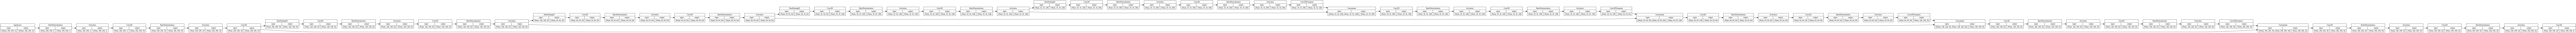

In [ ]:
# 呼叫模型
model1 = Unet2D(input_size=[256,256,1], init_filters=16)
model2 = Unet2D_simple(input_size=[256,256,1], init_filters=16)

# 查看模型的所有layer
model1.summary()

# 繪製模型流程圖
keras.utils.plot_model(model1, show_layer_names=False, show_shapes=True, rankdir='LR')

In [ ]:
# 查看縮減版模型的所有layer
# model2.summary()

# 繪製縮減版模型的流程圖
keras.utils.plot_model(model2, show_layer_names=False, show_shapes=True, rankdir='LR')
del model1, model2

### 建立訓練用模型

In [ ]:
model = Unet2D_simple(input_size=[256,256,1], init_filters=16, n_classes=2)

### 撰寫讀取資料集的function

In [ ]:
class Liver(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, img_paths, lbl_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_paths = img_paths
    self.lbl_paths = lbl_paths

  def __len__(self):
    return len(self.lbl_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_img_paths = self.img_paths[i:i+self.batch_size]
    batch_lbl_paths = self.lbl_paths[i:i+self.batch_size]
    x = []
    for path in batch_img_paths:
      img = np.load(path)
      img[img < 25] = 25
      img[img > 175] = 175
      if img.size != self.img_size:
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_AREA)
      img = ((img-img.min())/(img.max()-img.min()+1e-3)).astype(np.float32)
      img = np.expand_dims(img, axis=-1)
      x.append(img)
    x = np.stack(x, axis=0)
    y = []
    for path in batch_lbl_paths:
      mask = np.load(path).astype(np.uint8)
      mask[mask > 0] = 1
      if mask.size != self.img_size:
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_AREA)
      mask = np.expand_dims(mask, axis=-1)
      mask_bg = np.ones(mask.shape) - mask
      mask = np.concatenate([mask, mask_bg], axis=-1)
      y.append(mask)
    y = np.stack(y, axis=0)
    return x, y

### 讀取檔案路徑 (LiTS 2017 Dataset)

In [ ]:
images = natsorted(glob.glob(f'{dataset_paths}/images/*.npy'))
labels = natsorted(glob.glob(f'{dataset_paths}/labels/*.npy'))
lengths = len(images)
train_images = images[:int(lengths*0.8)]
train_labels = labels[:int(lengths*0.8)]
test_images = images[int(lengths*0.8):]
test_labels = labels[int(lengths*0.8):]

### 確認 image 及 label 對應到同一張

In [ ]:
print(len(train_images), len(train_labels))
print(f'Image: {train_images[0]}, label: {train_labels[0]}')
print(f'Image: {test_images[42]}, label: {test_labels[42]}')

1160 1160
Image: /content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/images/000_045.npy, label: /content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/labels/000_045.npy
Image: /content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/images/041_058.npy, label: /content/drive/MyDrive/Colab Notebooks/CMUH-AIC Medical_Image_Test/labels/041_058.npy


### 確認CT影像及Mask有順利對應

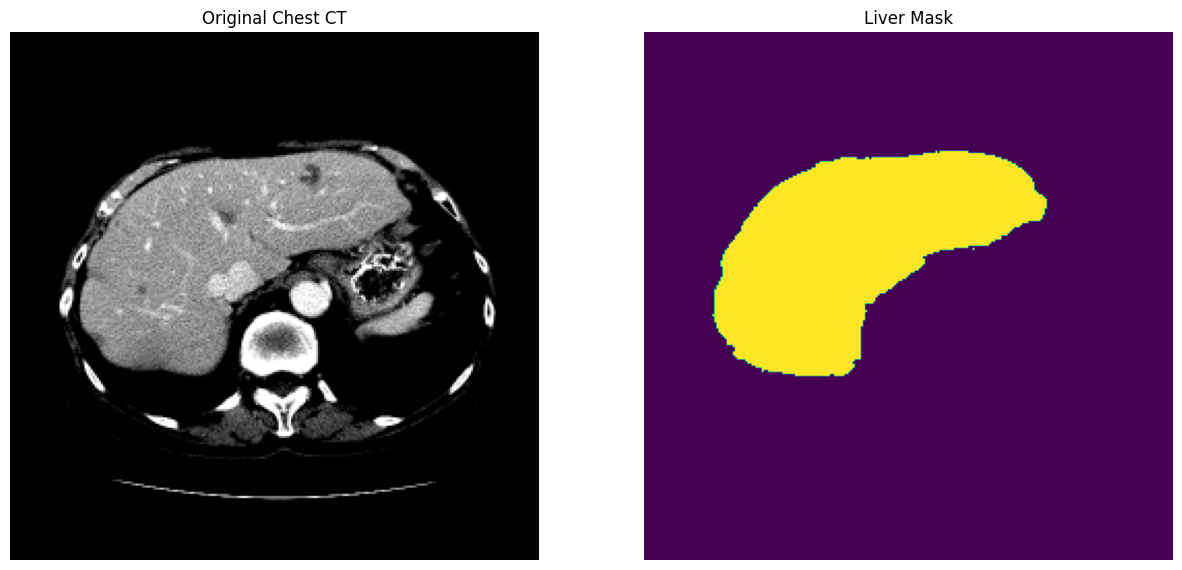

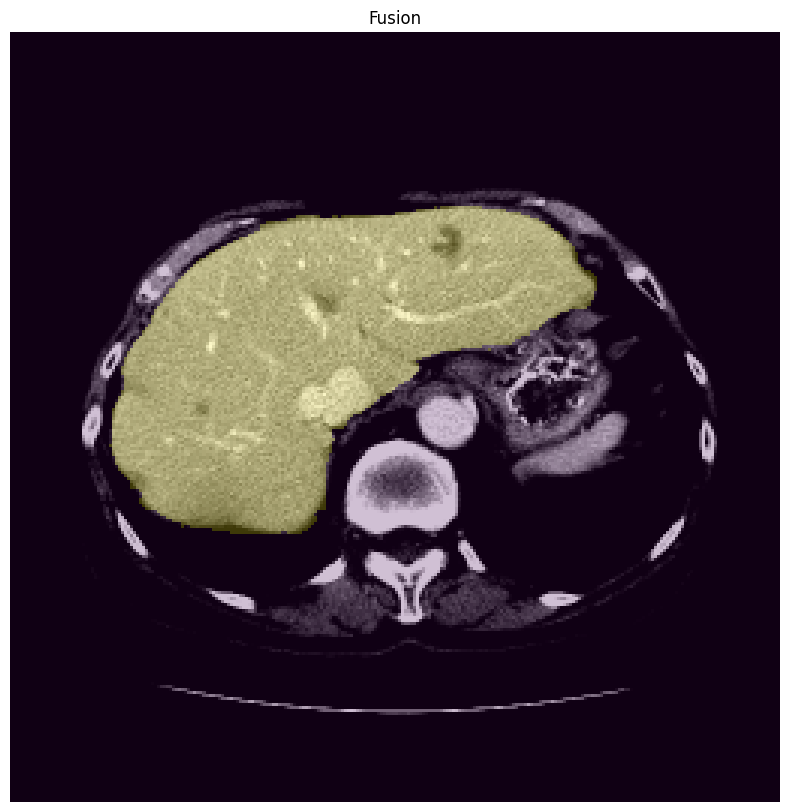

In [ ]:
train = Liver(1, (256, 256), train_images, train_labels)
image_temp, label_temp = train[50]
plt.figure(figsize=(15,15));
plt.subplot(121); plt.imshow(image_temp[0,...,0], cmap='gray'); plt.axis('off'); plt.title('Original Chest CT');
plt.subplot(122); plt.imshow(label_temp[0,...,0]); plt.axis('off'); plt.title('Liver Mask');
plt.figure(figsize=(10,10)); plt.imshow(image_temp[0,...,0], cmap='gray'); plt.imshow(label_temp[0,...,0], alpha=0.25); plt.axis('off'); plt.title('Fusion');

### 載入訓練集及驗證集

In [ ]:
train_gen = Liver(16, (256, 256), train_images, train_labels)
valid_gen = Liver(4, (256, 256), test_images, test_labels)

### 設定模型參數

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth))
  return dice

def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth))
  return K.categorical_crossentropy(y_true, y_pred) - K.log(dice)

In [ ]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=[dice_coef])

os.makedirs('/content/drive/MyDrive/Colab Notebooks/model', exist_ok=True)
# 設定檢查點 callbacks，模型存檔
modelcheckpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/model/UNet_model.h5", monitor='val_dice_coef', mode='max', save_best_only=True)
history = History()

In [ ]:
# 訓練 10 週期(epoch)
epochs = 10
model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[modelcheckpoint, history]);

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.3306 - dice_coef: 0.8607

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 249s 3s/step - loss: 0.3306 - dice_coef: 0.8607 - val_loss: 0.3233 - val_dice_coef: 0.8717
Epoch 2/10
72/72 [==============================] - 34s 474ms/step - loss: 0.1008 - dice_coef: 0.9534 - val_loss: 0.5442 - val_dice_coef: 0.8879
Epoch 3/10
72/72 [==============================] - 31s 430ms/step - loss: 0.0526 - dice_coef: 0.9756 - val_loss: 0.4581 - val_dice_coef: 0.9168
Epoch 4/10
72/72 [==============================] - 31s 429ms/step - loss: 0.0315 - dice_coef: 0.9852 - val_loss: 0.2710 - val_dice_coef: 0.9483
Epoch 5/10
72/72 [==============================] - 37s 521ms/step - loss: 0.0221 - dice_coef: 0.9897 - val_loss: 0.0828 - val_dice_coef: 0.9794
Epoch 6/10
72/72 [==============================] - 35s 477ms/step - loss: 0.0162 - dice_coef: 0.9925 - val_loss: 0.0268 - val_dice_coef: 0.9907
Epoch 7/10
72/72 [==============================] - 34s 471ms/step - loss: 0.0127 - dice_coef: 0.9942 - val_loss: 0.0156 - val_dice_coef: 0.993

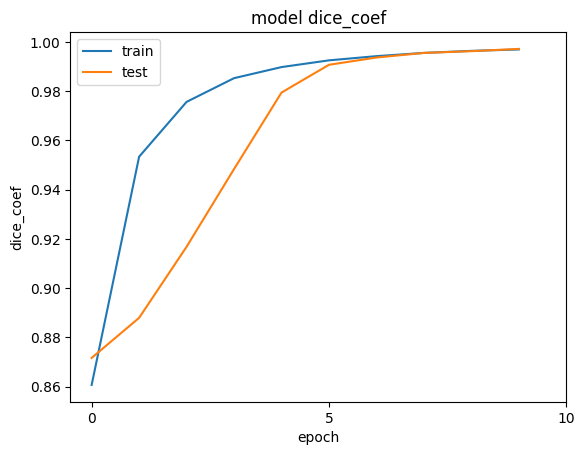

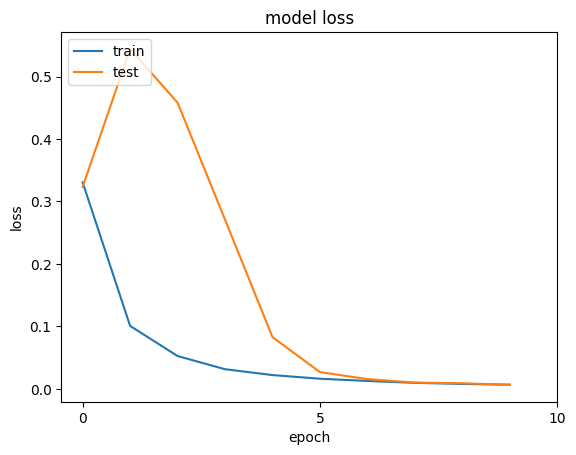

In [ ]:
plt.figure();
plt.plot(history.history['dice_coef']);
plt.plot(history.history['val_dice_coef']);
plt.title('model dice_coef'), plt.ylabel('dice_coef'), plt.xlabel('epoch'); plt.xticks(range(0,epochs+1,5));
plt.legend(['train', 'test'], loc='upper left');

plt.figure();
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title('model loss'), plt.ylabel('loss'), plt.xlabel('epoch'); plt.xticks(range(0,epochs+1,5));
plt.legend(['train', 'test'], loc='upper left');

### ResUNet

In [ ]:
def ConvBNRes(model, filters, block=None):
    model = Conv2D(filters, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    if block is not None:
        block = Conv2D(filters, kernel_size=(1,1), padding='same')(model)
        model = Add()([model, block])
    model = Activation('relu')(model)
    return model

def ResUnet2D(input_size, init_filters=16, n_classes=2):

    # Encoder 第一層
    inputs = Input(shape=input_size) # 512x512x1
    tmp = inputs
    enc1 = ConvBNRes(inputs, filters=init_filters) # 512x512x16
    enc1 = ConvBNRes(enc1, filters=init_filters, block=tmp) # 512x512x16

    # Encoder 第二層
    enc2 = MaxPooling2D(pool_size=(2,2))(enc1) # 256x256x16
    tmp = enc2
    enc2 = ConvBNRes(enc2, filters=init_filters*2) # 256x256x32
    enc2 = ConvBNRes(enc2, filters=init_filters*2, block=tmp) # 256x256x32

    # Encoder 第三層
    enc3 = MaxPooling2D(pool_size=(2,2))(enc2) # 128x128x32
    tmp = enc3
    enc3 = ConvBNRes(enc3, filters=init_filters*4) # 128x128x64
    enc3 = ConvBNRes(enc3, filters=init_filters*4, block=tmp) # 128x128x64

    # Encoder 第四層
    enc4 = MaxPooling2D(pool_size=(2,2))(enc3) # 64x64x64
    tmp = enc4
    enc4 = ConvBNRes(enc4, filters=init_filters*8) # 64x64x128
    enc4 = ConvBNRes(enc4, filters=init_filters*8, block=tmp) # 64x64x128

    # 最底層
    enc5 = MaxPooling2D(pool_size=(2,2))(enc4) # 32x32x128
    tmp = enc5
    enc5 = ConvBNRes(enc5, filters=init_filters*16) # 32x32x256
    enc5 = ConvBNRes(enc5, filters=init_filters*16, block=tmp) # 32x32x256

    # Decoder 第一層 (對應Encoder4)
    dec4 = Conv2DTranspose(init_filters*8, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(enc5) # 64x64x128
    tmp = dec4
    dec4 = Concatenate(axis=-1)([dec4, enc4]) # 64x64x256
    dec4 = ConvBNRes(dec4, filters=init_filters*8) # 64x64x128
    dec4 = ConvBNRes(dec4, filters=init_filters*8, block=tmp) # 64x64x128

    # Decoder 第二層 (對應Encoder3)
    dec3 = Conv2DTranspose(init_filters*4, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec4) # 128x128x64
    tmp = dec3
    dec3 = Concatenate(axis=-1)([dec3, enc3]) # 128x128x128
    dec3 = ConvBNRes(dec3, filters=init_filters*4) # 128x128x64
    dec3 = ConvBNRes(dec3, filters=init_filters*4, block=tmp) # 128x128x64

    # Decoder 第三層 (對應Encoder2)
    dec2 = Conv2DTranspose(init_filters*2, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec3) # 256x256x32
    tmp = dec2
    dec2 = Concatenate(axis=-1)([dec2, enc2]) # 256x256x64
    dec2 = ConvBNRes(dec2, filters=init_filters*2) # 256x256x32
    dec2 = ConvBNRes(dec2, filters=init_filters*2, block=tmp) # 256x256x32

    # Decoder 第四層 (對應Encoder1)
    dec1 = Conv2DTranspose(init_filters, kernel_size=(3,3), padding='same', strides=2, kernel_initializer='he_normal')(dec2) # 512x512x16
    tmp = dec1
    dec1 = Concatenate(axis=-1)([dec1, enc1]) # 512x512x32
    dec1 = ConvBNRes(dec1, filters=init_filters) # 512x512x16
    dec1 = ConvBNRes(dec1, filters=init_filters, block=tmp) # 512x512x16

    # 輸入端(Output要分為幾個class)
    out = Conv2D(n_classes, kernel_size=(1,1), padding='same')(dec1) # 512x512x2
    out = Activation('softmax')(out) # 512x512x2

    model = Model(inputs, out)
    return model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.920706 to fit



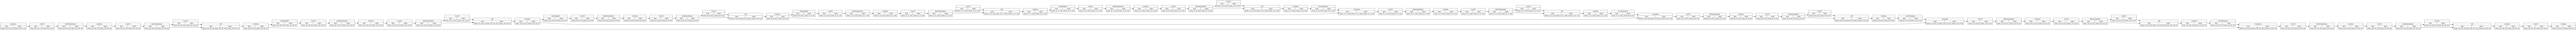

In [ ]:
# 呼叫模型
model_res = ResUnet2D(input_size=[256,256,1], init_filters=16)

# 查看模型的所有layer
# model1.summary()

# 繪製模型流程圖
keras.utils.plot_model(model_res, show_layer_names=False, show_shapes=True, rankdir='LR')

In [ ]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model_res.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef])

os.makedirs('/content/drive/MyDrive/Colab Notebooks/model', exist_ok=True)
# 設定檢查點 callbacks，模型存檔
modelcheckpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/model/ResUNet.h5", save_best_only=True)
history2 = History()

# 訓練 10 週期(epoch)
epochs = 10
model_res.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[modelcheckpoint, history2]);

Epoch 1/10
72/72 [==============================] - 46s 415ms/step - loss: 1.2499 - dice_coef: 0.6245 - val_loss: 1.2335 - val_dice_coef: 0.6222
Epoch 2/10
72/72 [==============================] - 27s 372ms/step - loss: 0.4304 - dice_coef: 0.8157 - val_loss: 1.2768 - val_dice_coef: 0.6878
Epoch 3/10
72/72 [==============================] - 31s 427ms/step - loss: 0.2718 - dice_coef: 0.8767 - val_loss: 1.2225 - val_dice_coef: 0.7544
Epoch 4/10
72/72 [==============================] - 29s 398ms/step - loss: 0.2033 - dice_coef: 0.9058 - val_loss: 0.6507 - val_dice_coef: 0.8304
Epoch 5/10
72/72 [==============================] - 26s 361ms/step - loss: 0.1597 - dice_coef: 0.9250 - val_loss: 0.3162 - val_dice_coef: 0.8874
Epoch 6/10
72/72 [==============================] - 27s 375ms/step - loss: 0.1294 - dice_coef: 0.9386 - val_loss: 0.1636 - val_dice_coef: 0.9287
Epoch 7/10
72/72 [==============================] - 29s 405ms/step - loss: 0.1084 - dice_coef: 0.9484 - val_loss: 0.1222 - val_dic

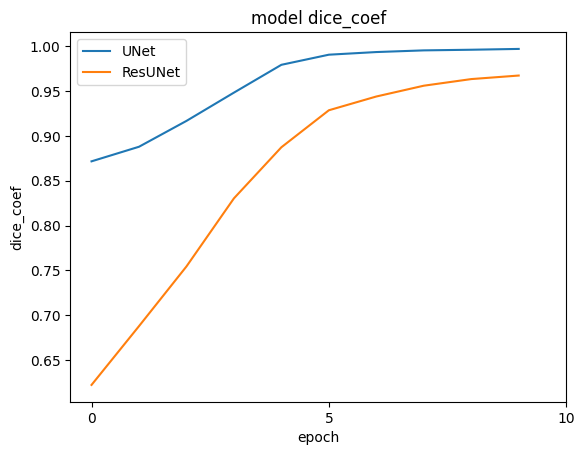

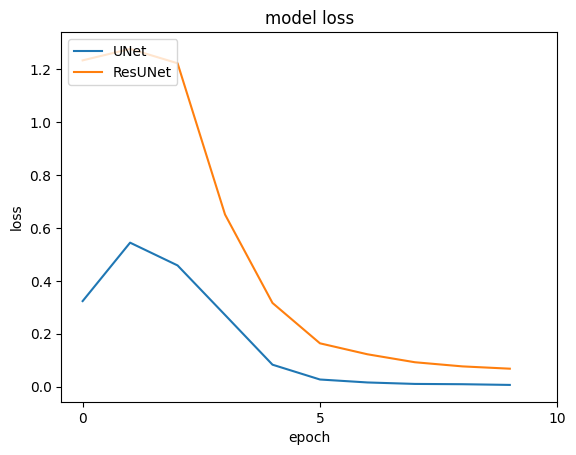

In [ ]:
plt.figure();
plt.plot(history.history['val_dice_coef']);
plt.plot(history2.history['val_dice_coef']);
plt.title('model dice_coef'), plt.ylabel('dice_coef'), plt.xlabel('epoch'); plt.xticks(range(0,epochs+1,5));
plt.legend(['UNet', 'ResUNet'], loc='upper left');

plt.figure();
plt.plot(history.history['val_loss']);
plt.plot(history2.history['val_loss']);
plt.title('model loss'), plt.ylabel('loss'), plt.xlabel('epoch'); plt.xticks(range(0,epochs+1,5));
plt.legend(['UNet', 'ResUNet'], loc='upper left');

### 從測試集拉出資料看模型預測的效果

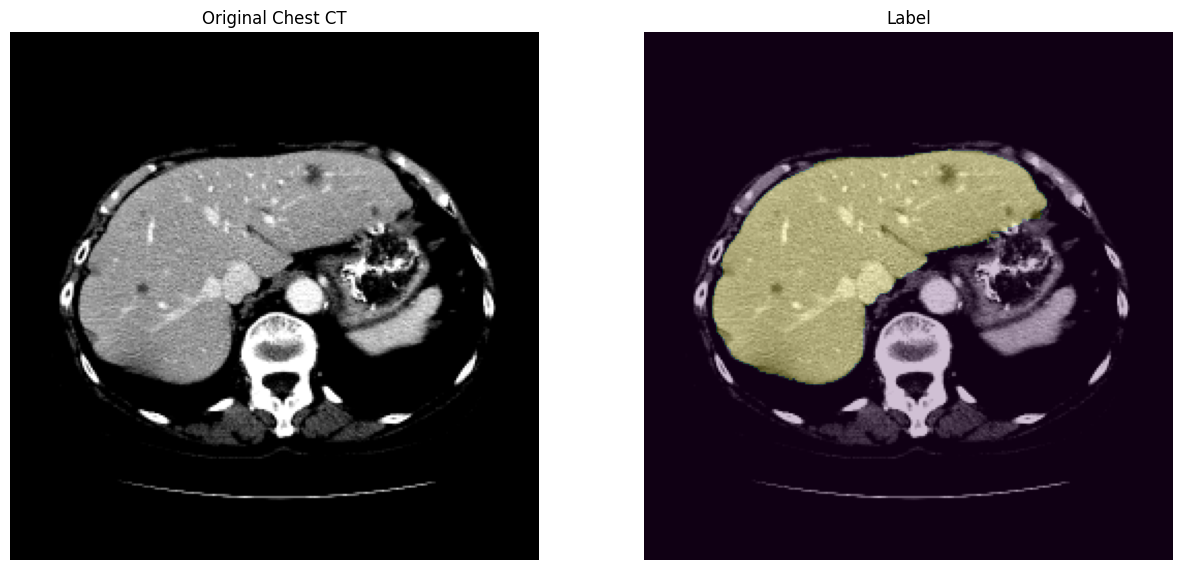

In [ ]:
test_gen = Liver(1, (256, 256), test_images, test_labels)
test_image, test_label = test_gen[20]
plt.figure(figsize=(15,15));
plt.subplot(121); plt.imshow(test_image[0,...,0], cmap='gray'); plt.axis('off'); plt.title('Original Chest CT');
plt.subplot(122); plt.imshow(test_image[0,...,0], cmap='gray'); plt.imshow(test_label[0,...,0], alpha=0.25); plt.axis('off'); plt.title('Label');

In [ ]:
test_pred1 = model.predict(test_image)
test_pred2 = model_res.predict(test_image)

1/1 [==============================] - 1s 562ms/step


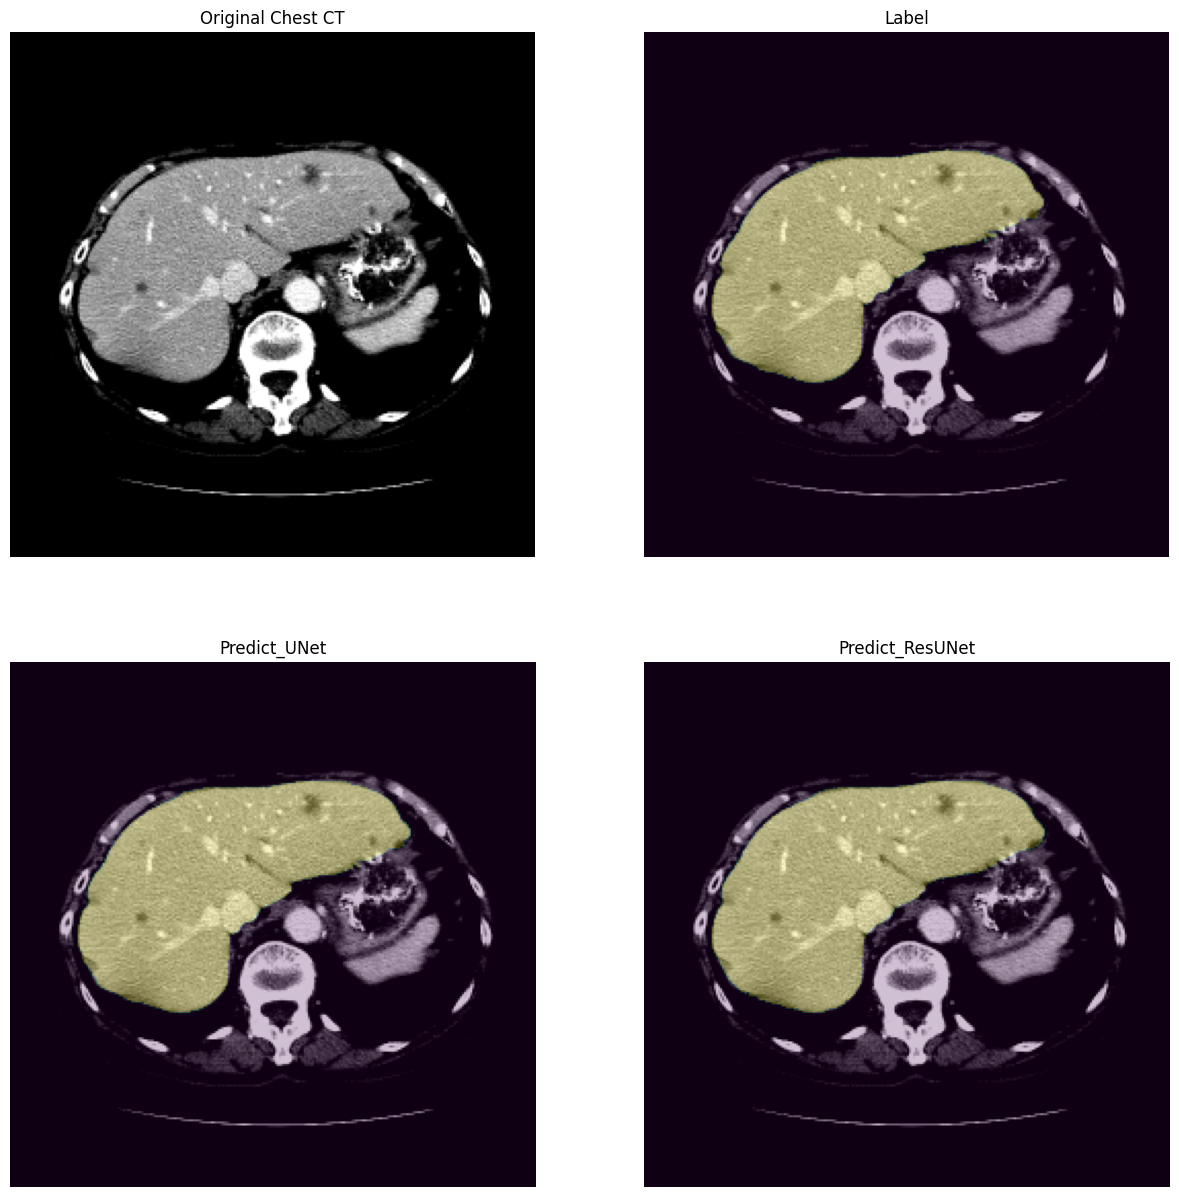

In [ ]:
plt.figure(figsize=(15,15));
plt.subplot(221); plt.imshow(test_image[0,...,0], cmap='gray'); plt.axis('off'); plt.title('Original Chest CT');
plt.subplot(222); plt.imshow(test_image[0,...,0], cmap='gray'); plt.imshow(test_label[0,...,0], alpha=0.25); plt.axis('off'); plt.title('Label');
plt.subplot(223); plt.imshow(test_image[0,...,0], cmap='gray'); plt.imshow(np.round(test_pred1[0,...,0]), alpha=0.25); plt.axis('off'); plt.title('Predict_UNet');
plt.subplot(224); plt.imshow(test_image[0,...,0], cmap='gray'); plt.imshow(np.round(test_pred2[0,...,0]), alpha=0.25); plt.axis('off'); plt.title('Predict_ResUNet');

### 讀取先前訓練的模型

In [ ]:
# model_new = load_model('/content/drive/MyDrive/Colab Notebooks/model/UNet_model.h5', compile=False)

In [ ]:
# test_pred3 = model_new.predict(test_image)

In [ ]:
# plt.figure(figsize=(15,15));
# plt.subplot(121); plt.imshow(test_image[0,...,0], cmap='gray'); plt.imshow(np.round(test_pred2[0,...,0]), alpha=0.25); plt.axis('off');
# plt.subplot(122); plt.imshow(test_image[0,...,0], cmap='gray'); plt.imshow(np.round(test_pred3[0,...,0]), alpha=0.25); plt.axis('off');